## Age Based on Image Regressor

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
from scipy.io import loadmat
from datetime import datetime

Dataset from https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
@article{Rothe-IJCV-2016,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {Deep expectation of real and apparent age from a single image without facial landmarks},
  journal = {International Journal of Computer Vision (IJCV)},
  year = {2016},
  month = {July},
}

Age extraction code based on https://github.com/yu4u/age-gender-estimation

In [6]:
path = Path('data/ages/wiki_crop')

In [7]:
def calc_age(taken, dob):
    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    # assume the photo was taken in the middle of the year
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [8]:
mat_path = path/'wiki.mat'

In [9]:
meta = loadmat(mat_path)

In [10]:
dob = meta['wiki'][0, 0]["dob"][0]  # Matlab serial date number

In [11]:
dob

array([723671, 703186, 711677, 705061, ..., 711338, 720620, 723893, 713846], dtype=int32)

In [12]:
photo_taken = meta['wiki'][0, 0]["photo_taken"][0]  # year

In [13]:
age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]

In [14]:
len(age)

62328

In [15]:
type(age)

list

In [16]:
age_array = np.array(age)

In [17]:
age_array

array([28, 39, 59, 31, ..., 22, 40, 29, 54])

In [18]:
pic_path = meta['wiki'][0, 0]["full_path"][0]

In [19]:
str(pic_path[0])

"['17/10000217_1981-05-05_2009.jpg']"

In [20]:
all_paths = [str(pic[0]) for pic in pic_path]

In [21]:
all_paths[0]

'17/10000217_1981-05-05_2009.jpg'

In [22]:
type(pic_path[0])

numpy.ndarray

In [23]:
tester = 24

In [24]:
test_path = str(pic_path[tester][0]); age[tester]

28

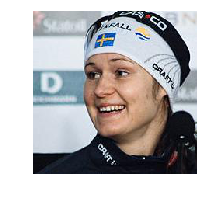

In [25]:
fname = path/test_path
img = open_image(fname)
img.show()

In [26]:
img.size

torch.Size([211, 211])

In [27]:
labels = pd.DataFrame(all_paths, columns=['fn_col'])

In [28]:
labels['label_col'] = age_array

In [29]:
labels.head()

,fn_col,label_col
0,17/10000217_1981-05-05_2009.jpg,28
1,48/10000548_1925-04-04_1964.jpg,39
2,12/100012_1948-07-03_2008.jpg,59
3,65/10001965_1930-05-23_1961.jpg,31
4,16/10002116_1971-05-31_2012.jpg,41


35

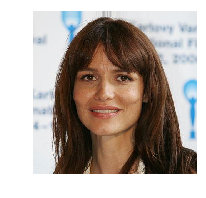

In [30]:
item_index = 273
img = open_image(path/labels['fn_col'][item_index])
img.show(); labels['label_col'][item_index]

In [31]:
labels.to_csv(path/'labels.csv', index=False, sep=',')

In [32]:
labels.describe()

,label_col
count,62328.000000
mean,36.559604
std,23.867147
min,-74.000000
25%,24.000000
50%,30.000000
75%,46.000000
max,1996.000000


In [33]:
labels[labels['label_col'] > 1000]

,fn_col,label_col
2546,09/430209_829-09-08_2006.jpg,1176
31487,70/2051570_647-05-15_2010.jpg,1363
32872,43/22504543_11-03-00_2007.jpg,1996


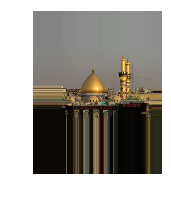

In [34]:
open_image(path/'70/2051570_647-05-15_2010.jpg').show()

In [35]:
labels.head(3)

,fn_col,label_col
0,17/10000217_1981-05-05_2009.jpg,28
1,48/10000548_1925-04-04_1964.jpg,39
2,12/100012_1948-07-03_2008.jpg,59


In [36]:
data = (ImageItemList.from_df(path=path, df=labels, cols='fn_col')
        .random_split_by_pct() 
#         .label_from_csv('labels.csv', folder=path, fn_col='fn_col', label_col='label_col')
#         .label_from_df(labels, fn_col='fn_col', label_col='label_col', label_cls=FloatList)
        .label_from_df(cols='label_col', label_cls=FloatList)
#         .label_from_list(labels['label_col'], label_cls=FloatList)
        .transform(get_transforms(), size=224)
        .databunch()
       )
data.normalize(imagenet_stats)

ImageDataBunch;
Train: LabelList
y: FloatList (49863 items)
[FloatItem 28.0, FloatItem 39.0, FloatItem 59.0, FloatItem 31.0, FloatItem 51.0]...
Path: .
x: ImageItemList (49863 items)
[Image (3, 257, 257), Image (3, 186, 186), Image (3, 457, 457), Image (3, 347, 500), Image (3, 185, 185)]...
Path: data/ages/wiki_crop;
Valid: LabelList
y: FloatList (12465 items)
[FloatItem 18.0, FloatItem 23.0, FloatItem 16.0, FloatItem 41.0, FloatItem 22.0]...
Path: .
x: ImageItemList (12465 items)
[Image (3, 202, 201), Image (3, 181, 182), Image (3, 500, 333), Image (3, 157, 158), Image (3, 281, 281)]...
Path: data/ages/wiki_crop;
Test: None

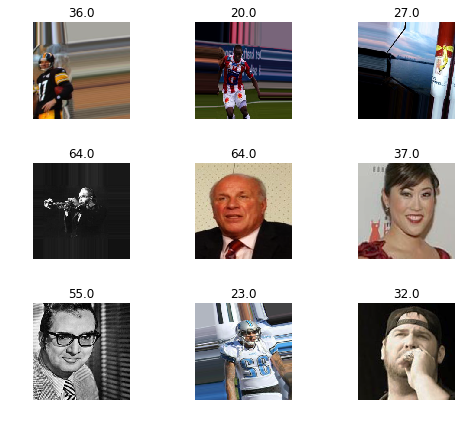

In [178]:
data.show_batch(rows=3, figsize=(7,6))

In [179]:
data.train_ds[0]

(Image (3, 224, 224), FloatItem 28.0)

In [180]:
data.train_ds.y

FloatList (49863 items)
[FloatItem 28.0, FloatItem 39.0, FloatItem 59.0, FloatItem 41.0, FloatItem 51.0]...
Path: .

In [37]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


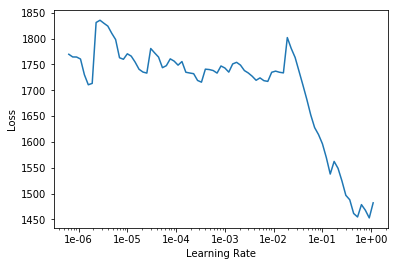

In [183]:
learn.lr_find()
learn.recorder.plot()

In [184]:
lr = 2e-1

In [185]:
learn.fit_one_cycle(5, slice(lr))

Total time: 11:43
epoch  train_loss  valid_loss  exp_rmspe 
1      406.156616  344.348145  nan         (03:01)
2      466.907227  371.095093  nan         (02:10)
3      384.621429  5654.727539  nan        (02:10)
4      338.517212  286.273926  nan         (02:10)
5      307.758575  258.211792  nan         (02:10)



In [186]:
learn.save('age-nov-stage-1')

In [187]:
learn.get_preds()

[tensor([[41.3566],
         [49.3066],
         [32.3957],
         ...,
         [31.9946],
         [33.7220],
         [32.2647]]), tensor([20., 46., 18.,  ..., 20., 43., 24.])]

In [188]:
learn.validate()

[258.2118, tensor(nan)]

In [189]:
   def my_predict(learner, img:Image):
        ds = learner.data.valid_ds
        ds.set_item(img)
        res = learner.pred_batch()[0]
        ds.clear_item()
        return res

In [190]:
my_predict(learn, img)

tensor([36.1080])

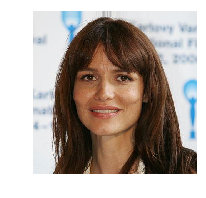

In [191]:
img.show()

In [192]:
learn.get_preds(with_loss=True)

[tensor([[41.3566],
         [49.3066],
         [32.3957],
         ...,
         [31.9946],
         [33.7220],
         [32.2647]]),
 tensor([20., 46., 18.,  ..., 20., 43., 24.]),
 tensor([456.1031,  10.9335, 207.2365,  ..., 143.8714,  86.0815,  68.3057])]

In [38]:
learn.load('age-nov-stage-1')

Learner(data=ImageDataBunch;
Train: LabelList
y: FloatList (49863 items)
[FloatItem 28.0, FloatItem 39.0, FloatItem 59.0, FloatItem 31.0, FloatItem 51.0]...
Path: .
x: ImageItemList (49863 items)
[Image (3, 257, 257), Image (3, 186, 186), Image (3, 457, 457), Image (3, 347, 500), Image (3, 185, 185)]...
Path: data/ages/wiki_crop;
Valid: LabelList
y: FloatList (12465 items)
[FloatItem 18.0, FloatItem 23.0, FloatItem 16.0, FloatItem 41.0, FloatItem 22.0]...
Path: .
x: ImageItemList (12465 items)
[Image (3, 202, 201), Image (3, 181, 182), Image (3, 500, 333), Image (3, 157, 158), Image (3, 281, 281)]...
Path: data/ages/wiki_crop;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Ba

In [40]:
test_image = open_image('./data/ages/estelle-getty.jpg')

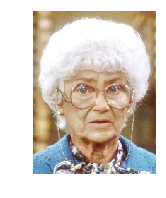

In [41]:
test_image.show()

In [50]:
float(learn.predict(test_image)[0][0])

81.2289810180664

In [45]:
test_image2 = open_image('./data/ages/js.jpeg')

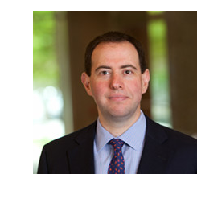

In [51]:
test_image2.show()

In [48]:
int(round(float(learn.predict(test_image2)[0][0]),0))

44

In [52]:
test_image3 = open_image('./data/ages/lhsProfilePicColor.jpg')

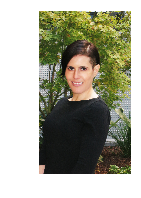

In [53]:
test_image3.show()

In [54]:
int(round(float(learn.predict(test_image3)[0][0]),0))

36

In [55]:
test_image4 = open_image('./data/ages/jss.jpeg')

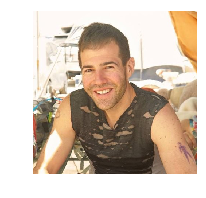

In [56]:
test_image4.show()

In [57]:
int(round(float(learn.predict(test_image4)[0][0]),0))

50